# Estimating Gentrification using Street View Images and Embeddings

This script (initially produced by ChatGPT) does the following (_this was my query_):
 - Read a spatial boundary file (that I will hard code)
 - Obtain the road network (from OSM?) for that area
 - Generate sample points on the road network roughly X meters apart
 - At each sample point, download the most recent street images for that location (either a single 360 degree view of a few smaller images). Use whichever API service is the most appropriate for obtaining the images. Importantly please record the date that the image was taken.
 - For each image, calculate an embedding using an appropriate foundation model (one that has been pre-trained to distinguish street environments specifically). Please use Hugging Face libraries.
 - If necessary, calculate the mean embedding for each point (is this the best way to calculate a single embedding for a point represented by multiple images?)
 - Now, for each sampled point there will be a dataframe with information about the point and its embedding. Read another polygon spatial data file, that I will provide, which contains area-level estimates of gentrification.
 - Use point-in-polygon to get the gentrification for each point.
 - Use cross-validation to train a couple of ML models (probaly random forest, linear regression and a neural network) to estimate gentrification from the embedding vectors
 - Choose the best model and parameter configuration and test this model on some held-out data.

## Configuration and library loading

In [1]:
import os
os.environ["HF_HOME"] = "/nfs/a319/gy17m2a/scratch/hf_cache"
from transformers import AutoImageProcessor, AutoModel
import random
import pickle
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
import osmnx as ox
import torch
from PIL import Image
import matplotlib.pyplot as plt
# # Hugging Face Transformers for image embedding
# from transformers import AutoImageProcessor, AutoModel  # will load a vision model

# # ----------------- Configuration -----------------
# #np.random.seed(42)
# density_per_km = 0.3  # number of points to sample per km of road
# #density_per_km = 0.1  # VERY FEW WHILE TESTING
DOWNLOAD_IMAGES = False  # If false then don't download any images, just load those that have been cached

data_dir = os.path.join("../../data/embeddings/")
boundary_file = os.path.join(data_dir, "greater_manchester_lsoas.geojson")  # Path to boundary polygon file
lsoas_file = os.path.join("../../data/SpatialData/", "LSOAs_2011", "LSOA_2011_EW_BSC_V4.shp")
n_directions = 4         # number of street view images per point (e.g., 4 cardinal directions)
# image_size = "640x640"   # requested image resolution from Street View API

# # Create directories for caching if not exist
# #Path(data_dir).mkdir(parents=True, exist_ok=True)
# image_dir = Path(os.path.join(data_dir, "street_images"))
# image_dir.mkdir(exist_ok=True)

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Loading

In [2]:
# --- Load neighbourhood polygons and dissolve to one study-area boundary ---
boundary_neighs = gpd.read_file(boundary_file)
# Make sure we're in WGS84 (lat/lon) for OSM and APIs
boundary_neighs = boundary_neighs.to_crs(epsg=4326)
# Dissolve: merge all geometries into one polygon (MultiPolygon possible)
boundary_polygon = boundary_neighs.union_all()  # shapely (multi)polygon
boundary_gdf = gpd.GeoDataFrame(data={'name': ['study_area']},
    geometry=[boundary_polygon], crs=boundary_neighs.crs)
print("Merged neighbourhoods into single study-area boundary.")
print("Bounds:", boundary_polygon.bounds)
# boundary_gdf.plot(color='lightblue', edgecolor='black')

Merged neighbourhoods into single study-area boundary.
Bounds: (-2.73052481406758, 53.3281053809015, -1.90962093258169, 53.6857339236763)


## Read the LSOA boundary data

(later it will be joined to the Greater Manchester Gentrification Index and IMD)

In [3]:
lsoas =  gpd.read_file(lsoas_file)
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
gm_lsoa=lsoas[lsoas['LSOA11NMW'].str.contains(manc_lads_pattern)]
gm_lsoa = gm_lsoa.to_crs(epsg=4326)
# gm_lsoa.plot()

### Load list of sample points

In [7]:
# Cache file for the entire points data with embeddings (images are stored separately)
DEBUG = False
points_data_cache = data_dir + "points_with_embeddings.pkl"

# -----------------------------------------------------------
# Load existing cache so we can *append* new sample points
# -----------------------------------------------------------
if os.path.isfile(points_data_cache):
    print("Loading cached point data …")
    with open(points_data_cache, "rb") as f:
        point_records = pickle.load(f)
    existing_coords = {(rec["latitude"], rec["longitude"]) for rec in point_records}
    next_id = max(rec["point_id"] for rec in point_records) + 1
else:
    point_records = []
    existing_coords = set()
    next_id = 0

print(f"Cache currently has {len(point_records)} points.")
added_this_run = 0

Loading cached point data …
Cache currently has 18897 points.


### Map of the full sample (cache + any others just downlaoded)

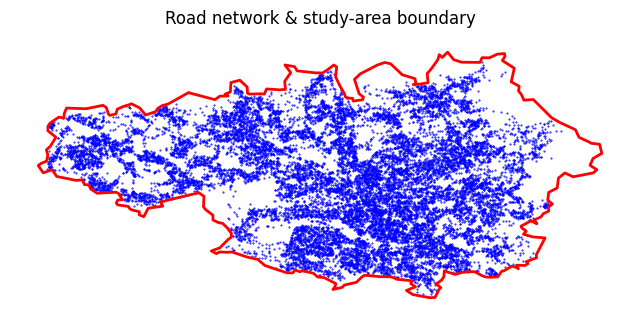

In [5]:
if point_records:    
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot roads first (thin gray lines)
    # edges_gdf.plot(ax=ax, linewidth=0.1, color="gray")

    # Plot the sample points
    gpd.GeoDataFrame(point_records, 
                     geometry=[Point(rec["longitude"], rec["latitude"]) for rec in point_records], 
                     crs="EPSG:4326").plot(ax=ax, color="blue", markersize=0.2, label="Sample Points")

    # Plot the study-area outline on top (thicker red line)
    boundary_gdf.boundary.plot(ax=ax, linewidth=2, edgecolor="red")

    ax.set_title("Road network & study-area boundary", pad=12)
    ax.set_axis_off()          # hides lat/lon ticks for a cleaner look
    ax.set_aspect("equal")     # keeps the map from looking stretched

    plt.show()

## Compute the Embeddings

(Note: would like to use Places365 but not available in Hugging Face yet, so using ViT base model instead)

In [10]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import os
from PIL import Image
import numpy as np
import pickle
import torch
from tqdm import tqdm  # <-- progress bar

# from transformers import AutoImageProcessor, AutoModel
# import torch

model_name = "google/vit-base-patch16-224-in21k"
print(f"Loading {model_name} …")
processor   = AutoImageProcessor.from_pretrained(model_name)
model       = AutoModel.from_pretrained(model_name).eval()   # no classifier head

# ----- device selection (CPU in your case) -----
device = torch.device("cpu")
model.to(device)
print("✔ Using CPU")


# -------------------------------------------------------------
# Function to embed a single image
# -------------------------------------------------------------
def embed_image(img_path):
    if not os.path.exists(img_path):
        return None
    img = Image.open(img_path).convert("RGB")
    inputs = processor(img, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        out = model(**inputs)
    cls = out.last_hidden_state[0, 0, :].cpu().numpy()
    return cls

# -------------------------------------------------------------
# Function to embed all images for a single point
# -------------------------------------------------------------
def embed_point(rec):
    embeds = []
    for img_path in rec["image_files"]:
        img_path = img_path.replace("airbnb-manchester/", "embeddings/").replace("../", "../../")
        cls = embed_image(img_path)
        if cls is not None:
            embeds.append(cls)
    rec["embedding"] = embeds
    return rec

# -------------------------------------------------------------
# Parallelize embedding over points with progress bar
# -------------------------------------------------------------
already_have_embedding = 0
point_records_out = []

with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    futures = [executor.submit(embed_point, rec) for rec in point_records]

    # Use tqdm to track progress
    for f in tqdm(as_completed(futures), total=len(futures), desc="Embedding points"):
        rec = f.result()
        point_records_out.append(rec)

point_records = point_records_out

print(f"Created {len(point_records)-already_have_embedding} new embeddings. "
      f"{already_have_embedding} points had existing embeddings.")

# -------------------------------------------------------------
# Cache the enriched records
# -------------------------------------------------------------
points_data_cache_with_embeddings = data_dir + "points_data_cache_with_embeddings.pkl"
with open(points_data_cache_with_embeddings, "wb") as f:
    pickle.dump(point_records, f)

print(f"✓ {len(point_records)} image embeddings computed and cached.")


Loading google/vit-base-patch16-224-in21k …
✔ Using CPU


Embedding points: 100%|██████████████████████████████████████████████████████| 18897/18897 [1:24:34<00:00,  3.72it/s]


Created 18897 new embeddings. 0 points had existing embeddings.
✓ 18897 image embeddings computed and cached.


In [ ]:
# -------------------------------------------------------------
# Load ViT-Base (ImageNet-21k) and pick CUDA ▸ MPS ▸ CPU device
# -------------------------------------------------------------

model_name = "google/vit-base-patch16-224-in21k"
print(f"Loading {model_name} …")
processor   = AutoImageProcessor.from_pretrained(model_name)
model       = AutoModel.from_pretrained(model_name).eval()   # no classifier head

# ----- smart device selection -----
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("✔ Using CUDA GPU")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")      # Apple-Silicon Metal
    print("✔ Using Apple MPS GPU")
else:
    device = torch.device("cpu")
    print("✔ Using CPU")

model.to(device)

# -------------------------------------------------------------
# Embed all images for each point
# -------------------------------------------------------------
already_have_embedding = 0
for rec in point_records:
    embeds = []
    # Skip records that already have an embedding
    # if rec.get("embedding") is not None:
    #     already_have_embedding += 1
    #     continue
    embeds = []
    for img_path in rec["image_files"]:
        img_path = img_path.replace("airbnb-manchester/", "embeddings/")
        img_path = img_path.replace("../", "../../")
        if not os.path.exists(img_path):
            continue
        # Load & convert to RGB (some JPEGs are encoded as P)
        img = Image.open(img_path).convert("RGB")

        # Tokenize and normalize the image
        inputs = processor(img, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}   # move tensors

        # Forward pass through the model (no gradients needed)
        with torch.no_grad():
            out = model(**inputs)

        # Extract the CLS token embedding (first token in the sequence)
        cls = out.last_hidden_state[0, 0, :].cpu().numpy()     # CLS token
        embeds.append(cls)

    # Store the mean embedding for this point (or none)
    rec["embedding"] = embeds # None if not embeds else np.mean(embeds, axis=0)

print(f"Created {len(point_records)-already_have_embedding} new embeddings. "
      f"{already_have_embedding} points had existing embeddings.")

# cache the enriched records
with open(points_data_cache, "wb") as f:
    pickle.dump(point_records, f)

print(f"✓ {len(point_records)} image embeddings computed and cached.")

Loading google/vit-base-patch16-224-in21k …
✔ Using CPU


In [11]:
# Check all records have an embeding
invalid_records = [rec for rec in point_records if rec.get('embedding') is None]
assert len(invalid_records)==0, f"Found {len(invalid_records)} invalid points"